In [ ]:
#LOGISTIC REGRESSION

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# 1. Tạo SparkSession, dùng thư mục tạm đã tạo ở D:/spark_temp
spark = SparkSession.builder \
    .appName("HeartAttackPrediction") \
    .config("spark.local.dir", "D:/spark_temp") \
    .getOrCreate()

# 2. Đọc dữ liệu
data_path = 'D:\\data\\heart_attack_china.csv'
df = spark.read \
    .option("header", "True") \
    .option("inferSchema", "True") \
    .option("sep", ",") \
    .csv(data_path)

print("There are", df.count(), "rows and", len(df.columns), "columns in the data.")

# 3. Chuyển cột label Heart_Attack sang số (0 hoặc 1)
df = df.withColumn("Heart_Attack", when(col("Heart_Attack") == "Yes", 1).otherwise(0))


There are 239266 rows and 28 columns in the data.


In [3]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# 3. Danh sách đặc trưng đầu vào (không bao gồm label)
indep_features = [
    "Age", "Gender", "Smoking_Status", "Hypertension", "Diabetes", "Obesity",
    "Cholesterol_Level", "Air_Pollution_Exposure", "Physical_Activity", "Diet_Score",
    "Stress_Level", "Alcohol_Consumption", "Family_History_CVD", "Healthcare_Access",
    "Rural_or_Urban", "Region", "Province", "Hospital_Availability", "TCM_Use",
    "Employment_Status", "Education_Level", "Income_Level", "Blood_Pressure",
    "Chronic_Kidney_Disease", "Previous_Heart_Attack", "CVD_Risk_Score"
]

# 4. Xác định các cột kiểu chuỗi cần encode
categorical_cols = [c for c, t in df.dtypes if t == "string" and c in indep_features]

# 5. Tạo StringIndexer cho các cột phân loại
indexers = [
    StringIndexer(inputCol=feature, outputCol=feature + "_idx", handleInvalid="keep")
    for feature in categorical_cols
]

# 6. Tạo danh sách cột đầu vào cho VectorAssembler
final_features = [
    feature + "_idx" if feature in categorical_cols else feature
    for feature in indep_features
]

# 7. VectorAssembler kết hợp đặc trưng
assembler = VectorAssembler(inputCols=final_features, outputCol="features")

# 8. Tạo pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# 9. Fit & transform pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# 10. Chọn cột đầu ra
df_final = df_transformed.select("features", "Heart_Attack")

# 11. Chia train/test
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# 12. Xem vài dòng kết quả
train_data.show(5)


+--------------------+------------+
|            features|Heart_Attack|
+--------------------+------------+
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
+--------------------+------------+
only showing top 5 rows



In [4]:
from pyspark.ml.classification import LogisticRegression

# Đặt tên biến label
target_feature = "Heart_Attack"

# Khởi tạo mô hình Logistic Regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol=target_feature,
    predictionCol="prediction",
    rawPredictionCol="rawPrediction",
    probabilityCol="probability",
    maxIter=10
)

# Huấn luyện mô hình và dự đoán
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)


In [5]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol=target_feature,
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol=target_feature)
area_under_curve = evaluator.evaluate(lr_predictions)
print(f"Area under ROC curve: {area_under_curve}")


Area under ROC curve: 0.6439146336644058


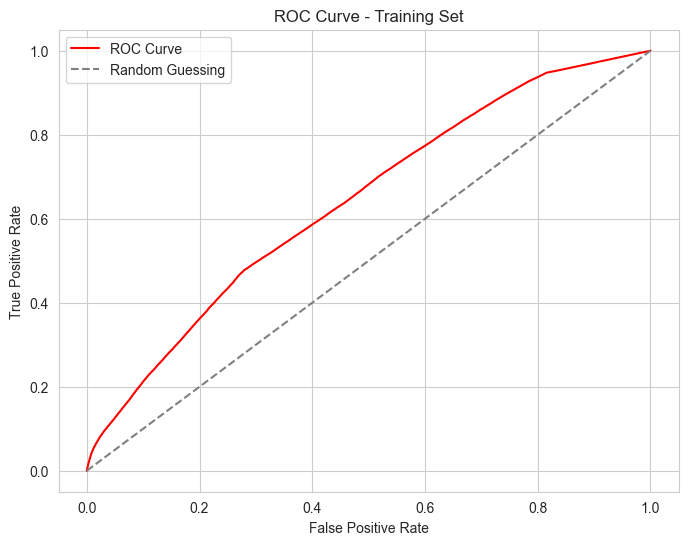

Training set areaUnderROC: 0.6409


In [6]:
from matplotlib import pyplot as plt
# Lấy training summary từ mô hình đã huấn luyện
trainingSummary = lr_model.summary

# Chuyển dữ liệu ROC về pandas để vẽ
lrROC = trainingSummary.roc.toPandas()

# Vẽ biểu đồ ROC
plt.figure(figsize=(8, 6))
plt.plot(lrROC['FPR'], lrROC['TPR'], label='ROC Curve', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.grid(True)
plt.legend()
plt.show()

# In chỉ số AUC trên tập huấn luyện
print('Training set areaUnderROC: {:.4f}'.format(trainingSummary.areaUnderROC))

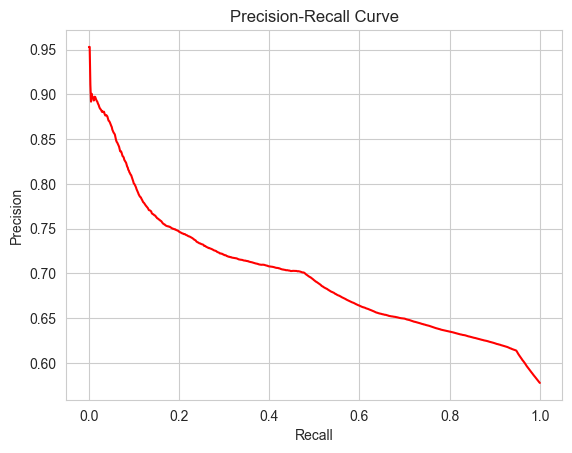

In [7]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'], color='red')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.title("Precision-Recall Curve")
plt.show()


In [10]:
from pyspark.sql.functions import column as col
# Calculate true positives, true negatives, false positives, false negatives
tp = lr_predictions.filter((col(target_feature) == 1) & (col('prediction') == 1)).count()
tn = lr_predictions.filter((col(target_feature) == 0) & (col('prediction') == 0)).count()
fp = lr_predictions.filter((col(target_feature) == 0) & (col('prediction') == 1)).count()
fn = lr_predictions.filter((col(target_feature) == 1) & (col('prediction') == 0)).count()
# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")
# Calculate precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
print(f"Precision: {precision}")
# Calculate recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
print(f"Recall: {recall}")
# Calculate F1 measure
f1_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
print(f"F1 measure: {f1_measure}")

Accuracy: 0.6243386243386243
Precision: 0.624993385193417
Recall: 0.8639722019019751
F1 measure: 0.7253047563484508


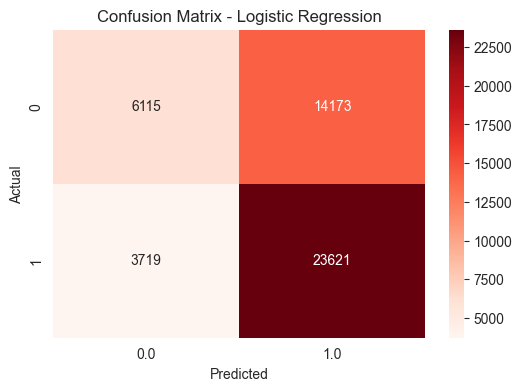

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert kết quả thành pandas DataFrame
preds_df = lr_predictions.select("prediction", "Heart_Attack").toPandas()

# Confusion matrix
conf_matrix = pd.crosstab(preds_df["Heart_Attack"], preds_df["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Vẽ
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


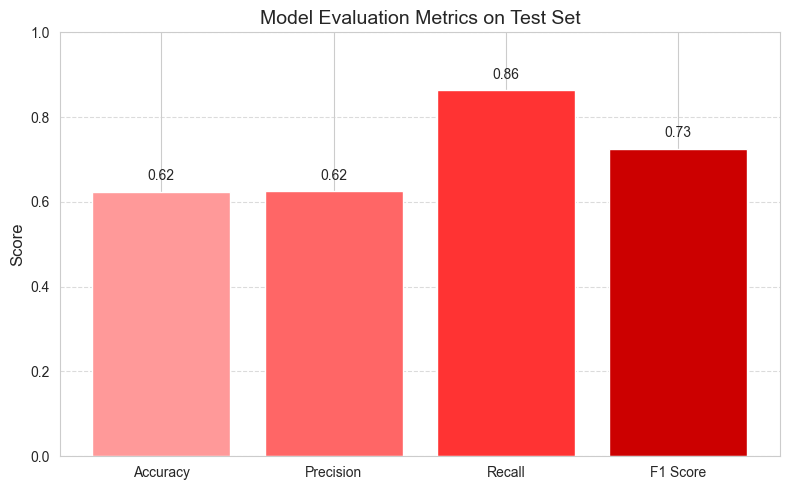

In [17]:
import matplotlib.pyplot as plt

# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_measure]

# Dùng tông đỏ cho tất cả cột
red_palette = ['#ff9999', '#ff6666', '#ff3333', '#cc0000']  # Từ nhạt đến đậm

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=red_palette)
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics on Test Set', fontsize=14)
plt.ylabel('Score', fontsize=12)

# Gắn giá trị lên đầu mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#DECISION TREE

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# 1. Tạo SparkSession đã tạo ở D:/spark_temp
spark = SparkSession.builder \
    .appName("HeartAttackPrediction") \
    .config("spark.local.dir", "D:/spark_temp") \
    .getOrCreate()

# 2. Đọc dữ liệu
data_path = 'D:\\data\\heart_attack_china.csv'
df = spark.read \
    .option("header", "True") \
    .option("inferSchema", "True") \
    .option("sep", ",") \
    .csv(data_path)

print("There are", df.count(), "rows and", len(df.columns), "columns in the data.")

# 3. Chuyển cột label Heart_Attack sang số (0 hoặc 1)
df = df.withColumn("Heart_Attack", when(col("Heart_Attack") == "Yes", 1).otherwise(0))

There are 239266 rows and 28 columns in the data.


In [3]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# 3. Danh sách đặc trưng đầu vào
indep_features = [
    "Age", "Gender", "Smoking_Status", "Hypertension", "Diabetes", "Obesity",
    "Cholesterol_Level", "Air_Pollution_Exposure", "Physical_Activity", "Diet_Score",
    "Stress_Level", "Alcohol_Consumption", "Family_History_CVD", "Healthcare_Access",
    "Rural_or_Urban", "Region", "Province", "Hospital_Availability", "TCM_Use",
    "Employment_Status", "Education_Level", "Income_Level", "Blood_Pressure",
    "Chronic_Kidney_Disease", "Previous_Heart_Attack", "CVD_Risk_Score"
]

# 4. Xác định các cột kiểu chuỗi cần encode
categorical_cols = [c for c, t in df.dtypes if t == "string" and c in indep_features]

# 5. Tạo StringIndexer cho các cột phân loại
indexers = [
    StringIndexer(inputCol=feature, outputCol=feature + "_idx", handleInvalid="keep")
    for feature in categorical_cols
]

# 6. Tạo danh sách cột đầu vào cho VectorAssembler
final_features = [
    feature + "_idx" if feature in categorical_cols else feature
    for feature in indep_features
]

# 7. VectorAssembler kết hợp đặc trưng
assembler = VectorAssembler(inputCols=final_features, outputCol="features")

# 8. Tạo pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# 9. Fit & transform pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# 10. Chọn cột đầu ra
df_final = df_transformed.select("features", "Heart_Attack")

# 11. Chia train/test
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# 12. Xem vài dòng kết quả
train_data.show(5)

+--------------------+------------+
|            features|Heart_Attack|
+--------------------+------------+
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
|(26,[0,1,2,3,4,5,...|           1|
+--------------------+------------+
only showing top 5 rows



In [5]:
from pyspark.ml.classification import DecisionTreeClassifier

# Khởi tạo mô hình Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Heart_Attack", maxDepth=5)

# Huấn luyện mô hình trên tập train
dt_model = dt.fit(train_data)

# Dự đoán trên tập test
dt_predictions = dt_model.transform(test_data)

In [6]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Đánh giá mô hình Decision Tree
evaluator = BinaryClassificationEvaluator(labelCol="Heart_Attack")
area_under_curve = evaluator.evaluate(dt_predictions)
print(f"Area under ROC curve: {area_under_curve}")

Area under ROC curve: 0.5730672256954139


In [7]:
from pyspark.sql.functions import col

tp = dt_predictions.filter((col("Heart_Attack") == 1) & (col('prediction') == 1)).count()
tn = dt_predictions.filter((col("Heart_Attack") == 0) & (col('prediction') == 0)).count()
fp = dt_predictions.filter((col("Heart_Attack") == 0) & (col('prediction') == 1)).count()
fn = dt_predictions.filter((col("Heart_Attack") == 1) & (col('prediction') == 0)).count()

accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")

precision = tp / (tp + fp) if (tp + fp) != 0 else 0
print(f"Precision: {precision}")

recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
print(f"Recall: {recall}")

f1_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
print(f"F1 measure: {f1_measure}")

Accuracy: 0.6320231796422272
Precision: 0.6221072015129647
Recall: 0.9144111192392099
F1 measure: 0.7404555282409738


In [ ]:
#SVM

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Tạo SparkSession
spark = SparkSession.builder \
    .appName("HeartAttackPrediction_SVM") \
    .config("spark.local.dir", "D:/spark_temp") \
    .getOrCreate()

# 2. Đọc dữ liệu
data_path = 'D:\\data\\heart_attack_china.csv'
df = spark.read.option("header", "True") \
    .option("inferSchema", "True") \
    .option("sep", ",") \
    .csv(data_path)

print(f"Data rows: {df.count()}, columns: {len(df.columns)}")

Data rows: 239266, columns: 28


In [9]:
# 3. Chuyển cột label Heart_Attack sang số (0 hoặc 1)
df = df.withColumn("Heart_Attack", when(col("Heart_Attack") == "Yes", 1).otherwise(0))

# 4. Danh sách các đặc trưng input (thay thế bằng cột thực tế trong dataset)
indep_features = [
    "Age", "Gender", "Smoking_Status", "Hypertension", "Diabetes", "Obesity",
    "Cholesterol_Level", "Air_Pollution_Exposure", "Physical_Activity", "Diet_Score",
    "Stress_Level", "Alcohol_Consumption", "Family_History_CVD", "Healthcare_Access",
    "Rural_or_Urban", "Region", "Province", "Hospital_Availability", "TCM_Use",
    "Employment_Status", "Education_Level", "Income_Level", "Blood_Pressure",
    "Chronic_Kidney_Disease", "Previous_Heart_Attack", "CVD_Risk_Score"
]

# 5. Xác định các cột categorical cần encode
categorical_cols = [c for c, t in df.dtypes if t == "string" and c in indep_features]

# 6. Tạo StringIndexer cho các cột categorical
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep") for c in categorical_cols]

# 7. Tạo danh sách features cuối cùng, thay thế categorical bằng cột index
final_features = [c + "_idx" if c in categorical_cols else c for c in indep_features]

# 8. VectorAssembler để gom tất cả features thành 1 vector
assembler = VectorAssembler(inputCols=final_features, outputCol="features")

# 9. Tạo pipeline gồm indexers và assembler
pipeline = Pipeline(stages=indexers + [assembler])

# 10. Fit & transform dữ liệu
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# 11. Chọn cột features và label
df_final = df_transformed.select("features", "Heart_Attack")

# 12. Chia dữ liệu train/test
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

In [10]:
# 13. Khởi tạo mô hình Linear SVC
svm = LinearSVC(featuresCol="features", labelCol="Heart_Attack", maxIter=10, regParam=0.1)

# 14. Huấn luyện mô hình trên train
svm_model = svm.fit(train_data)

# 15. Dự đoán trên test
svm_predictions = svm_model.transform(test_data)

# 16. Đánh giá với AUC
evaluator = BinaryClassificationEvaluator(labelCol="Heart_Attack", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(svm_predictions)
print(f"Area under ROC curve (SVM): {auc:.4f}")

# 17. Tính các chỉ số TP, TN, FP, FN
tp = svm_predictions.filter((col("Heart_Attack") == 1) & (col("prediction") == 1)).count()
tn = svm_predictions.filter((col("Heart_Attack") == 0) & (col("prediction") == 0)).count()
fp = svm_predictions.filter((col("Heart_Attack") == 0) & (col("prediction") == 1)).count()
fn = svm_predictions.filter((col("Heart_Attack") == 1) & (col("prediction") == 0)).count()

# 18. Tính Accuracy, Precision, Recall, F1 Score
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Accuracy (SVM): {accuracy:.4f}")
print(f"Precision (SVM): {precision:.4f}")
print(f"Recall (SVM): {recall:.4f}")
print(f"F1 Score (SVM): {f1:.4f}")

# 19. Dừng SparkSession
spark.stop()

Area under ROC curve (SVM): 0.6375
Accuracy (SVM): 0.6189
Precision (SVM): 0.6229
Recall (SVM): 0.8521
F1 Score (SVM): 0.7197
